In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm

from graph import _get_genes, _get_phenotypes, _get_positive_negative_edges, _load_gen_df, _load_phn_df, _merge_dfs

In [2]:
dfs = []

for i in tqdm(range(100)):
    df = pd.read_csv(f'results_multiseed/results_{i}.csv')
    dfs.append(df)

df = pd.concat(dfs).groupby(['Gen', 'Phn']).agg('mean').reset_index()
df

  0%|          | 0/100 [00:00<?, ?it/s]

,Gen,Phn,p
0,A2M,C1007,0.345865
1,A2M,C1010,0.190525
2,A2M,C1052,0.377902
3,A2M,C1067,0.096974
4,A2M,C1068,0.131648
...,...,...,...
703003,sep-09,L2003,0.003941
703004,sep-09,L2004,0.004348
703005,sep-09,L2005,0.008028
703006,sep-09,L2006,0.005035


In [3]:
df_gen = _load_gen_df()
df_phn = _load_phn_df()

genes = _get_genes(df_gen, df_phn)
phenotypes = _get_phenotypes(df_phn)

positive_edges, _ = _get_positive_negative_edges(_merge_dfs(df_gen, df_phn), genes, phenotypes)
positive_edges = pd.DataFrame({'Gen': positive_edges['Nod_B'], 'Phn': positive_edges['Nod_A'], 'GT': 1})
positive_edges

,Gen,Phn,GT
0,CDK11B,D1071,1
1,CDK11A,D1071,1
2,NADK,D1071,1
3,GNB1,D1071,1
4,PRDM16,D1071,1
...,...,...,...
684045,NCKAP1,D1095,1
693846,PPP1R13B,D1222,1
702637,ATP5MJ,D1222,1
702638,TDRD9,D1222,1


In [4]:
df = pd.merge(df, positive_edges, on=['Gen', 'Phn'], how='left').fillna(0)
df['GT'] = df['GT'].astype(int)
df

,Gen,Phn,p,GT
0,A2M,C1007,0.345865,0
1,A2M,C1010,0.190525,0
2,A2M,C1052,0.377902,0
3,A2M,C1067,0.096974,0
4,A2M,C1068,0.131648,0
...,...,...,...,...
703003,sep-09,L2003,0.003941,0
703004,sep-09,L2004,0.004348,0
703005,sep-09,L2005,0.008028,0
703006,sep-09,L2006,0.005035,0


Plot probability distribution returned by the model:

<AxesSubplot:>

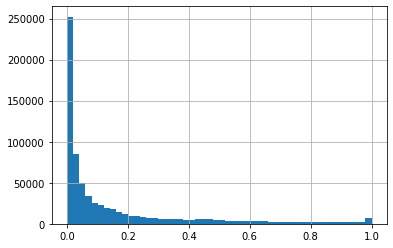

In [5]:
df['p'].hist(bins=50)

Compute performance metrics across all cross-validation folds:

In [6]:
y_test = df['GT'].values
y_prob = df['p'].values
y_pred = (y_prob > 0.5).astype(int)

{
    'Acc': np.round(accuracy_score(y_test, y_pred), 4),
    'BAC': np.round(balanced_accuracy_score(y_test, y_pred), 4),
    'Precision': np.round(precision_score(y_test, y_pred), 4),
    'Recall': np.round(recall_score(y_test, y_pred), 4),
    'PR-AUC': np.round(average_precision_score(y_test, y_prob), 4),
    'AUC': np.round(roc_auc_score(y_test, y_prob), 4),
}

{'Acc': 0.9053,
 'BAC': 0.9054,
 'Precision': 0.1218,
 'Recall': 0.9054,
 'PR-AUC': 0.5369,
 'AUC': 0.9624}

Plot confusion matrix, with probability threshold for link prediction = 0.5:

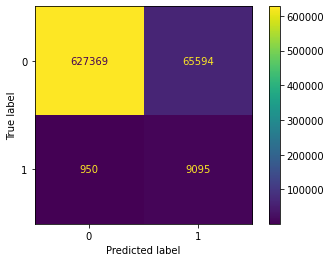

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Plot confusion matrix, with probability threshold for link prediction = 0.9:

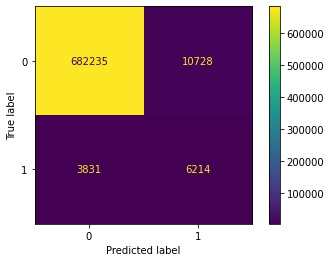

In [8]:
cm = confusion_matrix(y_test, (y_prob > 0.9).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

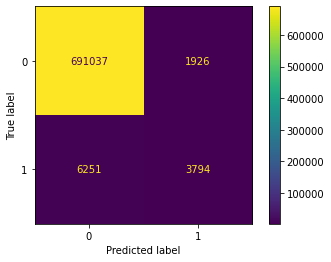

In [9]:
cm = confusion_matrix(y_test, (y_prob > 0.99).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Split dataframe into known (`df_o`) and unknown (`df_n`) links:

In [10]:
df_o = df[df['GT'] == 1].copy()
df_o

,Gen,Phn,p,GT
62,A2M,HumAge,0.949958,1
79,A4GNT,D1071,0.856645,1
146,AAAS,C1052,0.150735,1
279,AAK1,HumCel,0.724170,1
655,AASDH,D1071,0.849887,1
...,...,...,...,...
701830,ZSWIM8,D1351,0.463587,1
701844,ZSWIM8,D1595,0.456576,1
701899,ZSWIM8-AS1,D1320,0.709933,1
701902,ZSWIM8-AS1,D1351,0.759452,1


For unknown links also compute the hits at both thresholds (0.5 and 0.9):

In [11]:
df_n = df[df['GT'] == 0].copy()
df_n['h.50'] = (df_n['p'] > 0.50).astype(int)
df_n['h.90'] = (df_n['p'] > 0.90).astype(int)
df_n['h.99'] = (df_n['p'] > 0.99).astype(int)
df_n

,Gen,Phn,p,GT,h.50,h.90,h.99
0,A2M,C1007,0.345865,0,0,0,0
1,A2M,C1010,0.190525,0,0,0,0
2,A2M,C1052,0.377902,0,0,0,0
3,A2M,C1067,0.096974,0,0,0,0
4,A2M,C1068,0.131648,0,0,0,0
...,...,...,...,...,...,...,...
703003,sep-09,L2003,0.003941,0,0,0,0
703004,sep-09,L2004,0.004348,0,0,0,0
703005,sep-09,L2005,0.008028,0,0,0,0
703006,sep-09,L2006,0.005035,0,0,0,0


Count the number of known links per phenotype:

In [12]:
df_o['Phn'].value_counts()

D1071    1105
D1251    1022
D1249    1003
D1075     752
D1536     494
         ... 
D1074       3
D1312       3
D1154       1
D1280       1
D1095       1
Name: Phn, Length: 72, dtype: int64

Count the number of predicted unknown links per phenotype:

In [13]:
df_n.groupby('Phn')[['h.50', 'h.90', 'h.99']].agg('sum').reset_index()

,Phn,h.50,h.90,h.99
0,C1007,104,0,0
1,C1010,406,10,0
2,C1052,135,1,0
3,C1067,363,31,0
4,C1068,364,16,0
...,...,...,...,...
67,L2003,281,0,0
68,L2004,232,0,0
69,L2005,333,0,0
70,L2006,200,0,0


In [14]:
counts = df_n.groupby('Phn')[['h.50', 'h.90', 'h.99']].agg('sum')
counts = counts.merge(df_o['Phn'].value_counts().to_frame(), left_index=True, right_index=True)
counts = counts.rename(columns={'Phn': '# of known edges'})
counts = counts[['# of known edges', 'h.50', 'h.90', 'h.99']]
counts = counts.sort_values('# of known edges', ascending=False)

print(counts.to_string())

        # of known edges  h.50  h.90  h.99
D1071               1105  8243  1774   370
D1251               1022  3686   488    51
D1249               1003  3229   402    38
D1075                752  1929   273    22
D1536                494  4794   772    69
D1250                482  1149   363    20
D1416                396  1129   368    50
D1245                372  2371   603   249
D1153                369  1118   354    74
ModDRm               334  6916  1214   197
HumAge               307  5360   710    71
D1524                295  1109   351   151
HumCel               279  5843   830   117
D1155                263  1068   362   139
D1284                259  1076   350   106
D1526                221  3076   563    71
D1269                157  1087   345   131
C1010                153   406    10     0
C1068                115   364    16     0
D1523                111   863   305     0
C1069                110   361    16     0
D1085                 87   380     1     0
D1112      

Create dataframe containing probability matrix of predicted link probability between genes and phenotypes:

In [15]:
rows = []

for gene in tqdm(genes):
    row = []
    
    ds = df[df['Gen'] == gene]
    
    for phenotype in phenotypes:
        dx = ds[ds['Phn'] == phenotype]
        
        assert len(dx) == 1
        
        if dx['GT'].iloc[0] == 1:
            row.append(np.nan)
        else:
            row.append(dx['p'].iloc[0])
    
    rows.append(row)

dm = pd.DataFrame(rows, columns=phenotypes)
dm

  0%|          | 0/9764 [00:00<?, ?it/s]

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1351,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222
0,NaN,0.762423,0.459412,0.618451,0.558234,0.404973,0.819988,0.029462,0.028783,0.020855,...,0.014461,0.008831,0.006259,0.026983,0.003542,0.025409,0.000142,0.045500,0.008834,0.014029
1,NaN,0.787366,0.619648,0.676811,0.649650,0.514042,0.853605,0.030408,0.028844,0.039467,...,0.011015,0.012336,0.006953,0.025916,0.010062,0.064342,0.001307,0.053974,0.008806,0.017273
2,NaN,NaN,0.366063,0.527992,0.480692,0.309654,0.608432,0.017880,0.022591,0.020279,...,0.011125,0.010712,0.003070,0.016399,0.002761,0.028505,0.000138,0.030674,0.003330,0.008006
3,NaN,0.994122,0.962026,0.952167,0.951435,0.912784,0.997945,0.225681,0.207745,0.209524,...,0.073625,0.081074,0.010963,0.109652,0.048012,0.268852,0.006801,0.152126,0.031708,0.077301
4,NaN,0.543999,0.394831,0.518050,0.479212,0.321054,0.604340,0.021971,0.016644,0.018788,...,0.008266,0.008369,0.003322,0.013021,0.002147,0.022801,0.000719,0.025578,0.004855,0.013127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9759,0.722755,NaN,0.479184,0.445816,0.413460,0.399840,0.747867,0.029308,0.022193,0.020462,...,0.013244,0.014171,0.005384,0.033393,0.018648,0.081516,0.006142,0.041866,0.010178,0.028174
9760,0.715580,NaN,0.485996,0.439011,0.410564,0.386544,0.723300,0.024665,0.018804,0.022481,...,0.014195,0.009439,0.003213,0.027517,0.020840,0.094400,0.008234,0.063787,0.007241,0.016354
9761,0.733642,NaN,0.478622,0.424455,0.431947,0.386045,0.717856,0.020112,0.027222,0.022066,...,0.011612,0.011765,0.005496,0.036986,0.014583,0.085652,0.010725,0.048200,0.009091,0.018193
9762,0.704687,NaN,0.478585,0.471504,0.412309,0.387968,0.752473,0.026857,0.019358,0.020811,...,0.008966,0.011193,0.001967,0.028892,0.019401,0.081492,0.008030,0.049401,0.009700,0.027961


Add information about the sum of predicted probabilities for each gene:

In [16]:
dm.index = genes
dm['Total'] = dm[phenotypes].sum(axis=1)
dm = dm.sort_values('Total', ascending=False)
dm

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222,Total
KRAS,1.000000,0.999999,0.999964,0.999976,0.999955,0.999500,NaN,0.684472,0.670324,0.711261,...,0.316458,0.086435,0.335599,0.203560,0.708770,0.026717,0.428672,0.075845,0.188163,42.475629
TP53,0.999983,NaN,0.998507,0.999287,0.998364,0.995023,0.999999,0.622057,0.647831,0.609308,...,0.330896,0.057075,0.191807,0.126018,0.559107,0.009936,0.319983,0.053362,0.182630,37.386731
MAP3K4-AS1,NaN,0.312335,NaN,0.998712,0.997339,0.928455,0.290664,NaN,NaN,NaN,...,0.646622,0.062012,0.093455,0.081857,0.415345,0.011024,0.089523,0.018698,0.074191,37.266190
CTSH,0.987476,0.321720,0.968978,0.947017,0.953496,0.808418,0.284293,NaN,0.953212,0.949906,...,0.578935,0.091121,0.092565,0.116313,0.368725,0.012180,0.086462,0.024673,0.088000,37.023954
AGPAT4,NaN,0.259631,NaN,0.986567,0.980139,0.856046,0.237640,NaN,NaN,NaN,...,0.518028,0.057389,0.116627,0.096687,0.452134,0.007506,0.051129,0.007310,0.054278,36.576116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PURA,0.416900,0.398659,0.231955,0.222249,0.204694,0.177510,0.464008,0.004982,0.003975,0.004083,...,0.003944,0.002455,0.008874,0.001762,0.022705,0.000763,0.018329,0.003889,0.007981,3.389478
EGF,0.446996,0.536048,0.235515,0.230676,0.215237,0.196436,0.591174,0.004586,0.002532,0.002666,...,0.001583,0.002699,0.010056,0.002553,0.023343,0.000760,0.024727,0.004936,0.010715,3.386500
KIAA1524,0.439791,NaN,0.238836,0.224934,0.217812,0.193837,0.606953,0.004672,0.004497,0.003604,...,0.004253,0.001744,0.011737,0.002206,0.021929,0.000409,0.026771,0.002798,0.006718,3.367523
MAGEA2,0.421177,NaN,0.235293,0.220205,0.190561,0.183028,0.613304,0.004806,0.003963,0.002547,...,0.001910,0.002464,0.014512,0.005637,0.029614,0.000764,0.025713,0.007507,0.010140,3.286656


Show the sum of predicted probabilities for each phenotype:

In [17]:
print(dm[phenotypes].sum(axis=0).to_string())

D1071     6452.634611
HumCel    5447.252846
D1536     5184.313069
D1251     4633.283098
D1249     4435.960578
D1526     4486.647908
ModDRm    5899.588707
D1091      890.958620
D1092      882.201272
D1082      861.798096
L2001      913.752415
L2005      810.953914
D1112     1007.487345
D1111      838.364041
D1502      404.942160
D1085     1079.802199
D1245     3464.859250
D1075     2867.346665
D1183     1190.402964
D1182     1230.031153
D1156      872.742374
D1248      518.741124
C1007     1613.738378
D1525     1118.656452
HumAge    5329.679859
D1077      853.182762
D1321     1102.136329
C1010     1174.123586
C1068      919.809101
C1069      895.171534
D1250     1692.113390
D1416     1579.966083
D1153     1569.866720
D1524     1526.903679
D1269     1558.852552
D1284     1445.396550
D1523     1332.758314
D1537     1035.399216
D1320      933.138867
D1155     1475.394914
L2003      672.038585
D1159      981.123281
D1268      712.633712
C1080      435.972432
D1073      663.554477
D1076     

Calculate the number of known links for each gene, and compare that with the sum of predicted probabilities of novel ones:

In [18]:
dm['Known'] = dm.isna().sum(axis=1)

In [19]:
print(dm[['Total', 'Known']].iloc[:100].to_string())

                  Total  Known
KRAS          42.475629      1
TP53          37.386731      2
MAP3K4-AS1    37.266190     11
CTSH          37.023954      6
AGPAT4        36.576116      7
PRKN          36.400758      7
EGFR          36.393937      1
LINC01768     36.227739      7
NDUFA5P10     36.206988      7
POLR1G        36.188343     12
ADAMTS7       36.187276      5
RNU6-415P     36.058716      5
LPA           36.057769      8
MIR6088       35.954339     12
RPL21P116     35.869980      5
NAA25         35.689545     10
CDKN2B-AS1    35.647226     15
CHRNB4        35.316023      4
UBA52P6       35.126973      7
RPS2P41       34.545446     11
ERCC1         34.509000     13
PLG           34.497431      8
TCF25         34.488960      7
RPS16P9       34.380704      5
PPP1R13L      34.133305     12
ADAM1B        34.133230     10
MAP3K4        34.065758     11
ADAM1A        33.915171     10
ESR1          33.866091      4
TMEM116       33.755289     10
SLC22A3       33.705522      5
MYC     

Plot the histogram of sums of predicted probabilities for all genes:

<AxesSubplot:>

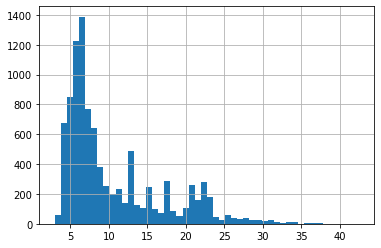

In [20]:
dm['Total'].hist(bins=50)